# Stable Diffusion 2.0 3x3 Grid

by Max Woolf (@minimaxir)

A notebook to generate images using Stable Diffusion 2.0 in a 3x3 grid using a cross of positive prompt additions and negative prompts/tokens.

You will need a login at [Hugging Face](https://huggingface.co) in order to download Stable Diffusion.

In [1]:
!nvidia-smi

Mon Nov 28 16:11:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -qq diffusers["torch"] transformers
!pip install -qq "ipywidgets>=7,<8"

In [3]:
from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler
import torch
from PIL import Image, ImageDraw, ImageFont
import os
from copy import deepcopy
from transformers import CLIPTextModel, CLIPTokenizer
import requests
from huggingface_hub import notebook_login, hf_hub_url
import zipfile

model_id = "stabilityai/stable-diffusion-2-base"

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [ ]:
notebook_login()

In [5]:
tokenizer = CLIPTokenizer.from_pretrained(
    model_id,
    subfolder="tokenizer",
    use_auth_token=True,
)
text_encoder = CLIPTextModel.from_pretrained(
    model_id, subfolder="text_encoder", use_auth_token=True
)

vocab_size = tokenizer.vocab_size

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


This cell downloads the `<wrong>` and `<midjourney>` embeds.

In [6]:
if not os.path.exists("midjourney.bin"):
    token_url=hf_hub_url(repo_id="minimaxir/wrong_embedding_sd_2_0",
                        filename="learned_embeds.bin")
    r = requests.get(token_url)
    open('wrong.bin', 'wb').write(r.content)

    token_url=hf_hub_url(repo_id="minimaxir/midjourney_sd_2_0",
                        filename="learned_embeds.bin")
    r = requests.get(token_url)
    open('midjourney.bin', 'wb').write(r.content)

In [7]:
def load_learned_embed_in_clip(learned_embeds_path, text_encoder, tokenizer, token=None):
  loaded_learned_embeds = torch.load(learned_embeds_path, map_location="cpu")
  
  # separate token and the embeds
  trained_token = list(loaded_learned_embeds.keys())[0]
  embeds = loaded_learned_embeds[trained_token]

  # cast to dtype of text_encoder
  dtype = text_encoder.get_input_embeddings().weight.dtype
  embeds.to(dtype)

  # add the token in tokenizer
  token = token if token is not None else trained_token
  num_added_tokens = tokenizer.add_tokens(token)
  if num_added_tokens == 0:
    raise ValueError(f"The tokenizer already contains the token {token}. Please pass a different `token` that is not already in the tokenizer.")
  
  # resize the token embeddings
  text_encoder.resize_token_embeddings(len(tokenizer))
  
  # get the id for the token and assign the embeds
  token_id = tokenizer.convert_tokens_to_ids(token)
  text_encoder.get_input_embeddings().weight.data[token_id] = embeds

  print(trained_token)


In [8]:
embed_paths = [
    "wrong.bin",
    "midjourney.bin"
]

for embed in embed_paths:
    load_learned_embed_in_clip(embed, text_encoder, tokenizer)

<wrong>
<midjourney>


In [9]:
scheduler = EulerAncestralDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
pipe = StableDiffusionPipeline.from_pretrained(model_id,
                                               scheduler=scheduler,
                                               text_encoder=text_encoder,
                                               tokenizer=tokenizer,
                                               revision="fp16",
                                               torch_dtype=torch.float16,
                                               safety_checker=None)
pipe = pipe.to("cuda")

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [10]:
def latents_generator(seed=0):
    g = torch.Generator(device='cuda')
    g.manual_seed(seed)

    latent_shape = (pipe.unet.in_channels,
                    512 // pipe.vae_scale_factor,
                    512 // pipe.vae_scale_factor)
    latent = torch.randn(latent_shape, generator=g, device="cuda")
    latent_batched = torch.repeat_interleave(latent.unsqueeze(0), 3, dim=0).to('cuda')
    return g, latent_batched


In [11]:
if not os.path.exists("fonts"):
    font_url = "https://fonts.google.com/download?family=Source%20Code%20Pro"
    r = requests.get(font_url, allow_redirects=True)
    open('fonts.zip', 'wb').write(r.content)

    with zipfile.ZipFile('fonts.zip', 'r') as zip_ref:
        zip_ref.extractall("fonts")

font = ImageFont.truetype(os.path.join('fonts', 'static', 'SourceCodePro-ExtraBold.ttf'), size=70)

def label_generator(label_text, text_color, bg_color):
    # Render at 2x then downsample for text AA
    image = Image.new('RGB', (400, 100), bg_color)
    image_editable = ImageDraw.Draw(image)
    image_editable.text((10,5), label_text.upper(), text_color, font=font, align="left")
    image = image.resize((image.width // 2, image.height // 2))
    return image

In [12]:
label_dict = {
    "original": label_generator("original", (0,0,0), (255,255,255)),
    "pos_prompt": label_generator("prompt", (255,255,255), (39,174,96)),
    "pos_token": label_generator("<token>", (255,255,255), (39,174,96)),
    "neg_prompt": label_generator("prompt", (255,255,255), (192,57,43)),
    "neg_token": label_generator("<token>", (255,255,255), (192,57,43)),

}

In [13]:
def prompt_builder(keys):
    return_dict = {"prompt": prompt_dict["original"],
                   "negative_prompt": ""}
    for key in keys:
        if key == "original":
            break
        else:
            if "pos" in key:
                return_dict["prompt"] += f", {prompt_dict[key]}"
            elif "neg" in key:
                return_dict["negative_prompt"] = prompt_dict[key]
    return return_dict
            

In [14]:
# probably don't have to hardcode it, but it's easier and ensures correct label order.
grid_order=[
    ["original"],
    ["pos_prompt"],
    ["pos_token"],
    ["neg_prompt"],
    ["pos_prompt", "neg_prompt"],
    ["pos_token", "neg_prompt"],
    ["neg_token"],
    ["pos_prompt", "neg_token"],
    ["pos_token", "neg_token"]
]

The main cells for running inference for the Grid.

`seed` can be an integer or a list of integers (e.g. `seed=[3**8, 3**9, 3**10, 3**11, 3**12]`); if a list, it will generate a grid for each seed. The seeds used in the post should reproduce the images given the same base prompt (in testing, it may not be a perfect reproduction due to internal RNG/CUDA shennanigans and PyTorch versioning)

Grids will be saved in the sidebar by seed; individual images without the labels will be saved in the `individual_outputs` folder.

In [15]:
seed = 19683
base_prompt = "a delicious hamburger"

pos_prompt = "hyper-detailed and intricate, realistic shaded, fine detail, realistic proportions, symmetrical, sharp focus, 8K resolution"
pos_token = "in the style of <midjourney>"
neg_prompt = "ugly, boring, bad anatomy"
neg_token = "in the style of <wrong>"

Seed used: 19683


  0%|          | 0/50 [00:00<?, ?it/s]

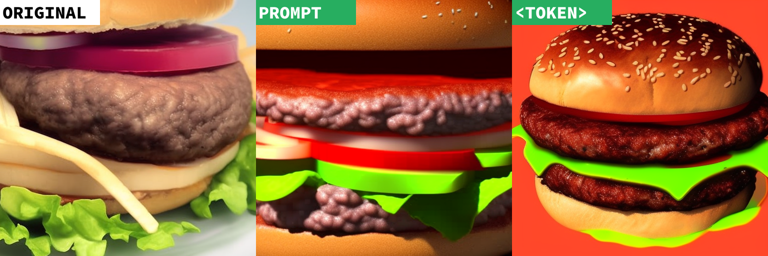

  0%|          | 0/50 [00:00<?, ?it/s]

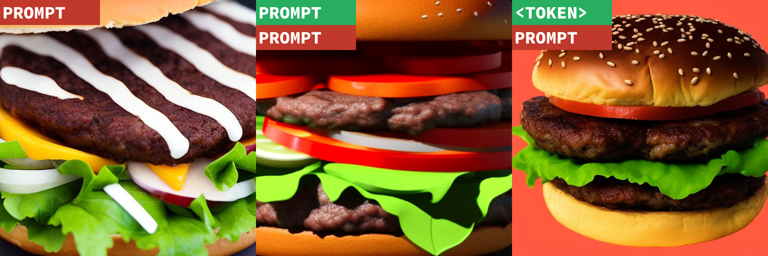

  0%|          | 0/50 [00:00<?, ?it/s]

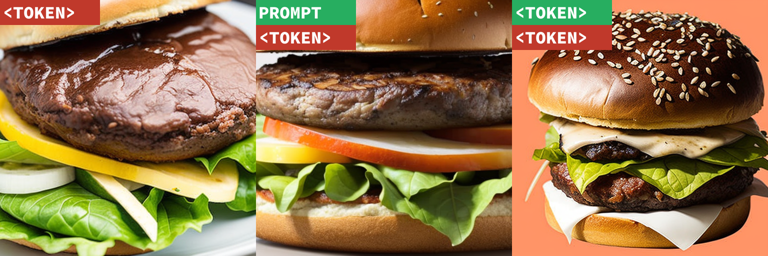

In [16]:
prompt_dict = {
    "original": base_prompt,
    "pos_prompt": pos_prompt,
    "pos_token": pos_token,
    "neg_prompt": neg_prompt,
    "neg_token": neg_token,

}

if isinstance(seed, int):
    seed = [seed]
    
if not os.path.exists("individual_outputs"):
    os.mkdir("individual_outputs")

for rng_seed in seed:
    print(f"Seed used: {rng_seed}")
    
    raw_outputs = []
    all_images = []
    
    g, latent_batched = latents_generator(rng_seed)
    for row in range(3):
        key_lists = grid_order[(row * 3) : (row * 3 + 3)]
        prompt_dicts = [prompt_builder(x) for x in key_lists]
        prompts = [x["prompt"] for x in prompt_dicts]
        negative_prompts = [x["negative_prompt"] for x in prompt_dicts]
        with torch.autocast("cuda"):
            g.manual_seed(rng_seed)  # reset seed before generation for deterministic sampling
            images = pipe(prompt=prompts,
                          negative_prompt=negative_prompts,
                          latents=latent_batched,
                          generator=g,
                          num_inference_steps=50, guidance_scale=7.5)["images"]
            
            # collect the unlabeled images for individual saving
            raw_outputs.extend(deepcopy(images))

            # paste label images onto each generated image
            for i in range(len(images)):
                labels = [label_dict[x] for x in key_lists[i]]
                label_vstack = image_grid(labels, len(labels), 1)
                images[i].paste(label_vstack)

            all_images.extend(images)
            image_large = image_grid(images, 1, 3)
            display(image_large.resize((image_large.width // 2, image_large.height // 2)))

    grid = image_grid(all_images, 3, 3)
    grid.save(f"promptgrid_seed_{rng_seed}.png")
    
    for i, image in enumerate(raw_outputs):
        image.save(os.path.join("individual_outputs", f"seed_{rng_seed}_{i+1:02d}.png"))

---

MIT License

Copyright (c) 2022 Max Woolf

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
